In [1]:
import pandas as pd
import numpy as np
import matplotlib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
file_path = "/content/processed_raman_data.csv"
df = pd.read_csv(file_path)
print(df)

      Raman Shift (cm^-1)  Metalaxyl-1  Metalaxyl-2  Metalaxyl-3  Metalaxyl-4  \
0               405.51088     0.016302     0.033555     0.041858     0.035378   
1               405.95199     0.022092     0.041618     0.037141     0.032837   
2               406.39306     0.027479     0.048755     0.034942     0.032730   
3               406.83411     0.032463     0.054966     0.035259     0.035057   
4               407.27512     0.035648     0.074608     0.040318     0.047280   
...                   ...          ...          ...          ...          ...   
3747           1842.52121     0.064646     0.045324     0.053217     0.032076   
3748           1842.85364     0.065796     0.045533     0.049845     0.032302   
3749           1843.18606     0.068062     0.044203     0.042224     0.033370   
3750           1843.51845     0.070280     0.040546     0.033437     0.035258   
3751           1843.85082     0.072450     0.034559     0.023483     0.037968   

      Metalaxyl-5  Metalaxy

In [3]:
!pip install ramanspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 51.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 16.9 MB/s eta 0:00:00
  Created wheel for pysptools: filename=pysptools-0.15.0-py3-none-any.whl size=8133731 sha256=5c781235f2012e3d93e96c204828c6cdbadf34eef2dfb9c8112ff1d74525bbf2
  Stored in directory: /root/.cache/pip/wheels/ea/08/3b/c045ea3722a5fef1f8698f060a17b59140235fef580fe4f1b5
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=5488fbcd9aa377b599fd31bd33b8ff1ae95288aa5309f341620307aeb0cd66ea
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built pysptools wget


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import ramanspy as rp
import numpy as np

def extract_top_peaks_in_bins(spectrum, bin_size=200, num_peaks_per_bin=3):
    spectral_axis = spectrum.spectral_axis
    spectral_data = spectrum.spectral_data

    bin_edges = np.arange(spectral_axis.min(), spectral_axis.max() + bin_size, bin_size)

    peak_positions = []
    peak_intensities = []
    feature_names = []

    for i in range(len(bin_edges) - 1):
        bin_name = f"Bin_{i + 1}"

        bin_mask = (spectral_axis >= bin_edges[i]) & (spectral_axis < bin_edges[i + 1])
        bin_wavelengths = spectral_axis[bin_mask]
        bin_intensities = spectral_data[bin_mask]
        if len(bin_wavelengths) > 0:
            bin_spectrum = rp.Spectrum(bin_intensities, bin_wavelengths)

            # find peaks in the current bin
            peaks, properties = bin_spectrum.peaks()

            # sort peaks by intensity and extract the top num_peaks_per_bin
            if len(peaks) > 0:
                peak_heights = properties.get('peak_heights', bin_spectrum.spectral_data[peaks])
                sorted_indices = np.argsort(peak_heights)[::-1]  # Sort in descending order
                top_indices = sorted_indices[:num_peaks_per_bin]

                # store the top peaks' positions and intensities
                top_positions = bin_wavelengths[peaks[top_indices]]
                top_intensities = peak_heights[top_indices]

                peak_positions.extend(top_positions)
                peak_intensities.extend(top_intensities)

                # add feature names for the top peaks in this bin
                feature_names.extend([f"{bin_name}_Pos_{j+1}" for j in range(len(top_positions))])
                feature_names.extend([f"{bin_name}_Intensity_{j+1}" for j in range(len(top_intensities))])

                # pad with -1 if fewer than required peaks found
                if len(top_positions) < num_peaks_per_bin:
                    peak_positions.extend([-1] * (num_peaks_per_bin - len(top_positions)))
                    peak_intensities.extend([-1] * (num_peaks_per_bin - len(top_intensities)))
                    feature_names.extend([f"{bin_name}_Pos_{j+1}" for j in range(len(top_positions), num_peaks_per_bin)])
                    feature_names.extend([f"{bin_name}_Intensity_{j+1}" for j in range(len(top_intensities), num_peaks_per_bin)])
            else:
                # no peaks found in this bin, pad with -1
                peak_positions.extend([-1] * num_peaks_per_bin)
                peak_intensities.extend([-1] * num_peaks_per_bin)
                feature_names.extend([f"{bin_name}_Pos_{j+1}" for j in range(num_peaks_per_bin)])
                feature_names.extend([f"{bin_name}_Int_{j+1}" for j in range(num_peaks_per_bin)])
        else:
            # no data in this bin, pad with -1
            peak_positions.extend([-1] * num_peaks_per_bin)
            peak_intensities.extend([-1] * num_peaks_per_bin)
            feature_names.extend([f"{bin_name}_Pos_{j+1}" for j in range(num_peaks_per_bin)])
            feature_names.extend([f"{bin_name}_Intensity_{j+1}" for j in range(num_peaks_per_bin)])

    return peak_positions, peak_intensities, feature_names



wavelengths = df['Raman Shift (cm^-1)'].values
x_cols = df.drop(columns=['Raman Shift (cm^-1)']).values.T

X = []
all_feature_names = []
for col in x_cols:
    features = []
    sp = rs.Spectrum(col, wavelengths)
    peaks, properties = sp.peaks()
    peak_positions, peak_intensities, feature_names = extract_top_peaks_in_bins(sp)
    features.extend(peak_positions)
    features.extend(peak_intensities)
    X.append(features)
    if not all_feature_names:
        all_feature_names.extend(feature_names)


X = np.array(X)

y = []
for column in df.drop(columns=['Raman Shift (cm^-1)']).columns:
    pesticide_type = column.split('-')[0]
    y.append(pesticide_type)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(y)
class_names = label_encoder.inverse_transform(np.unique(y))
class_names[1] = "Acetamiprid"
print(class_names)
X = X.reshape(len(df.drop(columns=['Raman Shift (cm^-1)']).columns), -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.47, random_state=42)

X_train_balanced = X_train
y_train_balanced = y_train

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)
rf = RandomForestClassifier(random_state=42)
cross_val_scores = cross_val_score(rf, X_train_scaled, y_train_balanced, cv=min(3, min(np.bincount(y_train_balanced))), n_jobs=-1, verbose=2)
rf.fit(X_train_scaled, y_train_balanced)
print(f"Cross-Validation Accuracy: {np.mean(cross_val_scores):.4f} (+/- {np.std(cross_val_scores):.4f})")

rf.fit(X_train_scaled, y_train_balanced)

y_pred = rf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Test Accuracy: {test_accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12  2  2  2  2  2  2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


Cross-Validation Accuracy: 1.0000 (+/- 0.0000)
Random Forest Test Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


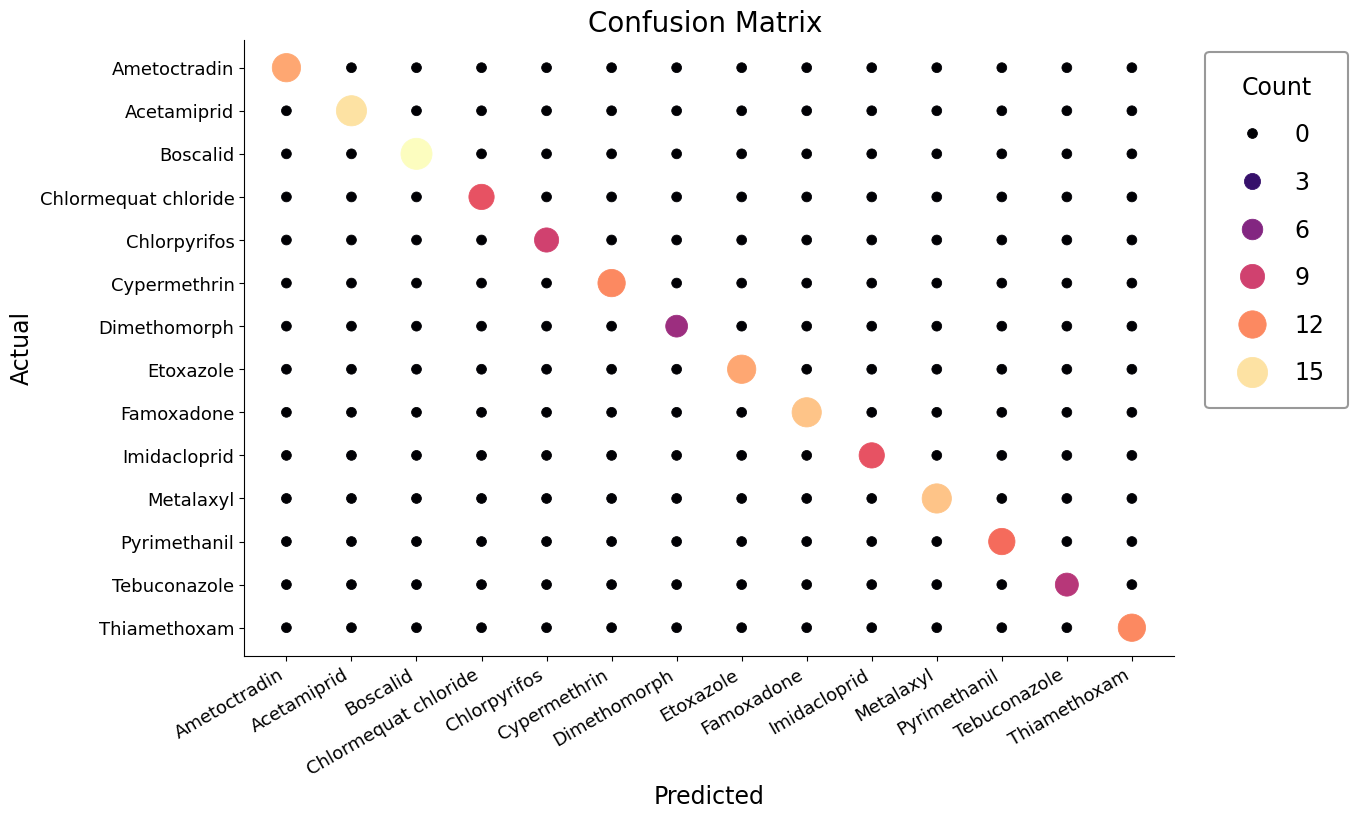

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# transforming confusion matrix into long form
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_long = df_cm.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
df_long.rename(columns={'index': 'Actual'}, inplace=True)

plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    data=df_long,
    x='Predicted',
    y='Actual',
    size='Count',
    hue='Count',
    sizes=(50, 500),
    palette= sns.color_palette("magma", as_cmap=True),
    edgecolor=None
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=30, ha='right', fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Confusion Matrix ', fontsize=20)
plt.xlabel('Predicted', fontsize=17)
plt.ylabel('Actual', fontsize=17)

legend = plt.legend(
    title='Count',
    fontsize=17,
    title_fontsize=17,
    bbox_to_anchor=(1.2, 1),
    loc='best',
    borderpad=1,
    labelspacing=1,
    frameon=True
)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor("gray")
plt.savefig("Confusion_Matrix_Improved.svg", format="svg",  bbox_inches="tight")




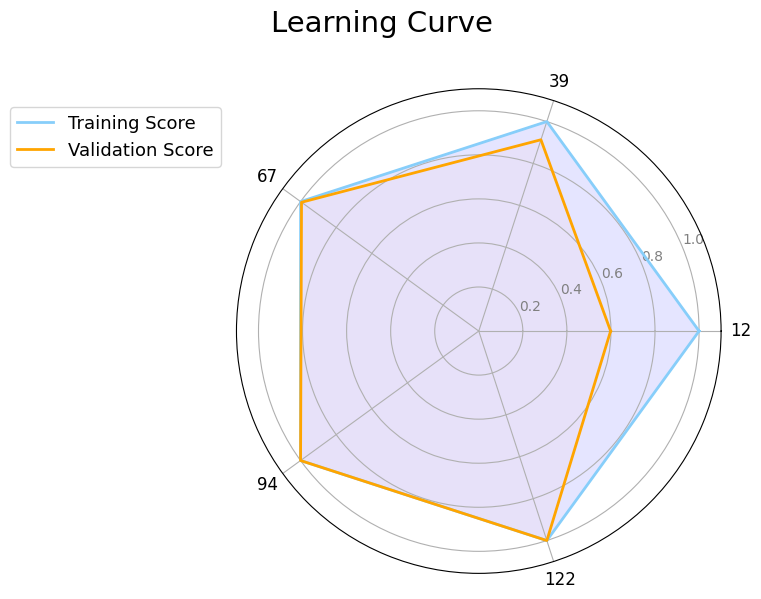

In [6]:
from sklearn.model_selection import learning_curve
from math import pi
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    rf, X_train_scaled, y_train_balanced, cv=min(3, min(np.bincount(y_train_balanced))), n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

categories = [str(s) for s in train_sizes]
values_training = list(train_mean) + [train_mean[0]]
values_validation = list(val_mean) + [val_mean[0]]

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, values_training, label='Training Score', color='lightskyblue', linewidth=2)
ax.fill(angles, values_training, alpha=0.1, color='blue')

ax.plot(angles, values_validation, label='Validation Score', color='orange', linewidth=2)
ax.fill(angles, values_validation, alpha=0.1, color='pink')  # Fill for validation

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10, color="gray")
ax.set_ylim(0, 1.1)

ax.set_aspect('equal')

plt.title('Learning Curve', fontsize=21, x= 0.3, y= 1.1)
ax.legend(loc='center', bbox_to_anchor=(-0.25, 0.9), fontsize=13, frameon=True)
plt.savefig('learning_curve_radar_chart.svg', format='svg', bbox_inches="tight")
plt.tight_layout()
plt.show()
